In [1]:
import pandas as pd
import numpy as np
import requests
import urllib

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Connection to RDS
server_info = 'DRIVER={SQL Server};SERVER=LAPTOP-7FR129DV\SQLEXPRESS;DATABASE=Fresh_Produce_Market_Data;TRUSTED_CONNECTION=yes'

In [4]:
# Creating a connection to MS SQL SERVER
params = urllib.parse.quote_plus(server_info)
engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)
connection = engine.connect()

In [5]:
# Upload sales data
sales = pd.read_sql_table(
    table_name='Durban_Fresh_produce_market',
    con=connection,
    parse_dates=['Date']
)

## Data preparation

In [6]:
# Check the first five rows
sales.head()

,Commodities,Weight_Kg,Size_Grade,Container,Province,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Date
0,ABC JUICE,0.33,,OA003,TRANSVAAL,0.00,0.00,0.00,0,0,0,1500,2020-08-20
1,ABC JUICE,0.75,,OB008,TRANSVAAL,0.00,0.00,0.00,0,0,0,530,2020-08-20
2,AMADUMBE,13.50,,A1135,NATAL,160.00,160.00,160.00,5600,35,472.5,19,2020-08-20
3,AMADUMBE,25.00,,SC250,NATAL,440.00,440.00,440.00,1760,4,100,0,2020-08-20
4,APPLE,0.33,,OA003,TRANSVAAL,0.00,0.00,0.00,0,0,0,2180,2020-08-20


In [7]:
# View datatype of each column
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224082 entries, 0 to 224081
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Commodities     224082 non-null  object        
 1   Weight_Kg       224082 non-null  object        
 2   Size_Grade      224082 non-null  object        
 3   Container       224082 non-null  object        
 4   Province        224082 non-null  object        
 5   Low_Price       224082 non-null  object        
 6   High_Price      224082 non-null  object        
 7   Average_Price   224082 non-null  object        
 8   Sales_Total     224082 non-null  object        
 9   Total_Qty_Sold  224082 non-null  object        
 10  Total_Kg_Sold   224082 non-null  object        
 11  Stock_On_Hand   224082 non-null  object        
 12  Date            224082 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(12)
memory usage: 22.2+ MB


In [8]:
# Convert some of the columns to their appropriate data type
float_columns = ['Weight_Kg', 'Low_Price', 'High_Price', 'Average_Price', 
                 'Sales_Total', 'Total_Kg_Sold', 'Total_Qty_Sold', 'Stock_On_Hand']


# Convert the columns to numeric
for col in float_columns:
    # sales[col] = sales[col].astype(float)
    sales[col] = pd.to_numeric(sales[col])

In [9]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224082 entries, 0 to 224081
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Commodities     224082 non-null  object        
 1   Weight_Kg       224082 non-null  float64       
 2   Size_Grade      224082 non-null  object        
 3   Container       224082 non-null  object        
 4   Province        224082 non-null  object        
 5   Low_Price       224082 non-null  float64       
 6   High_Price      224082 non-null  float64       
 7   Average_Price   224082 non-null  float64       
 8   Sales_Total     224081 non-null  float64       
 9   Total_Qty_Sold  224081 non-null  float64       
 10  Total_Kg_Sold   224082 non-null  float64       
 11  Stock_On_Hand   224081 non-null  float64       
 12  Date            224082 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(8), object(4)
memory usage: 22.2+ MB


In [10]:
sales.head()

,Commodities,Weight_Kg,Size_Grade,Container,Province,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Date
0,ABC JUICE,0.33,,OA003,TRANSVAAL,0.0,0.0,0.0,0.0,0.0,0.0,1500.0,2020-08-20
1,ABC JUICE,0.75,,OB008,TRANSVAAL,0.0,0.0,0.0,0.0,0.0,0.0,530.0,2020-08-20
2,AMADUMBE,13.50,,A1135,NATAL,160.0,160.0,160.0,5600.0,35.0,472.5,19.0,2020-08-20
3,AMADUMBE,25.00,,SC250,NATAL,440.0,440.0,440.0,1760.0,4.0,100.0,0.0,2020-08-20
4,APPLE,0.33,,OA003,TRANSVAAL,0.0,0.0,0.0,0.0,0.0,0.0,2180.0,2020-08-20


In [11]:
# Check for the number of days in the database
print(f"{sales['Date'].nunique()} days recorded in the database")

147 days recorded in the database


In [12]:
# Remove days whereby total sales equal 0 because it registers average_price as zero.
filtered_sales = sales[sales['Sales_Total'] != 0]

In [13]:
print(f"{filtered_sales['Date'].nunique()} days recorded in the database")

147 days recorded in the database


Therefore no days were lost due to filtering by 'Sales_Total'

In [14]:
filtered_sales.head()

,Commodities,Weight_Kg,Size_Grade,Container,Province,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Date
2,AMADUMBE,13.5,,A1135,NATAL,160.0,160.0,160.00,5600.0,35.0,472.5,19.0,2020-08-20
3,AMADUMBE,25.0,,SC250,NATAL,440.0,440.0,440.00,1760.0,4.0,100.0,0.0,2020-08-20
7,APPLE BRAEBURN,9.0,2L,JE090,CAPE,50.0,60.0,51.21,4865.0,95.0,855.0,334.0,2020-08-20
8,APPLE CRIPPS PINK,12.0,1L,EC120,CAPE,60.0,128.0,61.06,3908.0,64.0,768.0,237.0,2020-08-20
9,APPLE CRIPPS PINK,18.3,1L,M4183,CAPE,100.0,180.0,117.78,1060.0,9.0,164.7,307.0,2020-08-20


In [15]:
# Check PINEAPPLE commodity to observe daily sales
sales[(sales['Commodities'] == 'PINEAPPLE QUEEN VICTORIA') & (sales['Container'] == 'LM080') & (sales['Province'] == 'NATAL')].sort_values('Date').head(20)

,Commodities,Weight_Kg,Size_Grade,Container,Province,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Date
191857,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,85.0,85.0,85.00,340.0,4.0,32.0,0.0,2019-12-11
191858,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,75.0,75.0,75.00,1125.0,15.0,120.0,0.0,2019-12-11
151571,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,60.0,85.0,61.89,21784.0,352.0,2816.0,300.0,2019-12-12
151570,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,40.0,40.0,40.00,1760.0,44.0,352.0,6.0,2019-12-12
151569,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,56.0,56.0,56.00,7448.0,133.0,1064.0,260.0,2019-12-12
151568,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,65.0,65.0,65.00,29120.0,448.0,3584.0,2.0,2019-12-12
151567,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,56.0,75.0,74.87,56830.0,759.0,6072.0,32.0,2019-12-12
151566,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,85.0,85.0,85.00,74120.0,872.0,6976.0,637.0,2019-12-12
138687,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,75.0,75.0,75.00,14400.0,192.0,1536.0,180.0,2019-12-14
138689,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,56.0,56.0,56.00,3976.0,71.0,568.0,102.0,2019-12-14


Based on the above table, it can be seen that multiple sales are taking place on the same day, which means that the data has to be consolidated to one day.

In [16]:
# Consolidation of repeated sales in a single day of the same product to one day
df = filtered_sales.groupby(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities', 'Date']
    )[['Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold', 'Total_Kg_Sold', 'Stock_On_Hand']].agg(
        {
            'Low_Price':min,
            'High_Price':max,
            'Sales_Total':sum,
            'Total_Qty_Sold':sum,
            'Total_Kg_Sold':sum,
            'Stock_On_Hand':sum
        }
)

In [17]:
df

Low_Price  \
Province          Container Size_Grade Weight_Kg Commodities             Date                    
                  A8075                7.5       HABANERO YELLOW         2020-07-01      350.0   
                                                                         2020-07-08      350.0   
                                                                         2020-07-09      350.0   
                                                                         2020-07-14      350.0   
                                                                         2020-07-20      300.0   
...                                                                                        ...   
WESTERN FREESTATE PP100     4M         10.0      POTATO LANORMA (WASHED) 2020-03-10        8.0   
                            4R         10.0      POTATO (WASHED) MONDIAL 2020-01-23        5.0   
                            4S         10.0      POTATO (WASHED) MONDIAL 2020-01-23        5.0   
                                                                         2020-06-19        5.0   
                            4Z         10.0      POTATO (WASHED) MONDIAL 2020-06-19       20.0   

                                                                                     High_Price  \
Province          Container Size_Grade Weight_Kg Commodities             Date                     
                  A8075                7.5       HABANERO YELLOW         2020-07-01       350.0   
                                                                         2020-07-08       350.0   
                                                                         2020-07-09       350.0   
                                                                         2020-07-14       350.0   
                                                                         2020-07-20       320.0   
...                                                                                         ...   
WESTERN FREESTATE PP100     4M         10.0      POTATO LANORMA (WASHED) 2020-03-10        10.0   
                            4R         10.0      POTATO (WASHED) MONDIAL 2020-01-23        10.0   
                            4S         10.0      POTATO (WASHED) MONDIAL 2020-01-23         5.0   
                                                                         2020-06-19         5.0   
                            4Z         10.0      POTATO (WASHED) MONDIAL 2020-06-19        20.0   

                                                                                     Sales_Total  \
Province          Container Size_Grade Weight_Kg Commodities             Date                      
                  A8075                7.5       HABANERO YELLOW         2020-07-01       1400.0   
                                                                         2020-07-08       2800.0   
                                                                         2020-07-09       2800.0   
                                                                         2020-07-14       2100.0   
                                                                         2020-07-20       1240.0   
...                                                                                          ...   
WESTERN FREESTATE PP100     4M         10.0      POTATO LANORMA (WASHED) 2020-03-10       1080.0   
                            4R         10.0      POTATO (WASHED) MONDIAL 2020-01-23       5470.0   
                            4S         10.0      POTATO (WASHED) MONDIAL 2020-01-23       1440.0   
                                                                         2020-06-19       1670.0   
                            4Z         10.0      POTATO (WASHED) MONDIAL 2020-06-19         40.0   

                                                                                     Total_Qty_Sold  \
Province          Container Size_Grade Weight_Kg Commodities             Date                         
               

In [18]:
df.reset_index(inplace=True)

In [19]:
df.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand
0,,A8075,,7.5,HABANERO YELLOW,2020-07-01,350.0,350.0,1400.0,4.0,30.0,12.0
1,,A8075,,7.5,HABANERO YELLOW,2020-07-08,350.0,350.0,2800.0,8.0,60.0,24.0
2,,A8075,,7.5,HABANERO YELLOW,2020-07-09,350.0,350.0,2800.0,8.0,60.0,24.0
3,,A8075,,7.5,HABANERO YELLOW,2020-07-14,350.0,350.0,2100.0,6.0,45.0,4.0
4,,A8075,,7.5,HABANERO YELLOW,2020-07-20,300.0,320.0,1240.0,4.0,30.0,0.0


In [20]:
df['avg_price_per_kg'] = round(df['Sales_Total'] / df['Total_Kg_Sold'], 2)
df['low_price_per_kg'] = round(df['Low_Price'] / df['Weight_Kg'], 2)
df['high_price_per_kg'] = round(df['High_Price'] / df['Weight_Kg'], 2)

In [21]:
df.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg,low_price_per_kg,high_price_per_kg
0,,A8075,,7.5,HABANERO YELLOW,2020-07-01,350.0,350.0,1400.0,4.0,30.0,12.0,46.67,46.67,46.67
1,,A8075,,7.5,HABANERO YELLOW,2020-07-08,350.0,350.0,2800.0,8.0,60.0,24.0,46.67,46.67,46.67
2,,A8075,,7.5,HABANERO YELLOW,2020-07-09,350.0,350.0,2800.0,8.0,60.0,24.0,46.67,46.67,46.67
3,,A8075,,7.5,HABANERO YELLOW,2020-07-14,350.0,350.0,2100.0,6.0,45.0,4.0,46.67,46.67,46.67
4,,A8075,,7.5,HABANERO YELLOW,2020-07-20,300.0,320.0,1240.0,4.0,30.0,0.0,41.33,40.00,42.67


In [22]:
# Check which product is regularly sold based on the days in the data
day_count = sales['Date'].nunique()
df.groupby(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities'])['Commodities'].value_counts().apply(lambda x: x / day_count).sort_values(ascending=False)

Province  Container  Size_Grade  Weight_Kg  Commodities             Commodities           
CAPE      EC120      1S          12.0       APPLE GOLDEN DELICIOUS  APPLE GOLDEN DELICIOUS    1.000000
NATAL     ST170                  17.0       CHILLIES GREEN          CHILLIES GREEN            0.986395
          NE005                  0.5        CURRY LEAVES            CURRY LEAVES              0.986395
          BI100                  10.0       BRINJALS                BRINJALS                  0.986395
          AT200                  20.0       CABBAGE                 CABBAGE                   0.986395
                                                                                                ...   
          BF070      1L          7.0        CUCUMBERS ENGLISH       CUCUMBERS ENGLISH         0.006803
                                            LEMON                   LEMON                     0.006803
                     1M          7.0        CUCUMBERS ENGLISH       CUCUMBERS ENGLISH

Based on the results above, **APPLE GOLDEN DELICIOUS** has been sold for every day that is recorded in the database. For this notebook, this product will be used as a template for developing a forecasting model.

In [25]:
filtered_df = df[
    (df['Commodities'] == 'APPLE GOLDEN DELICIOUS') & 
    (df['Weight_Kg'] == 12.0) &
    (df['Size_Grade'] == '1S') &
    (df['Container'] == 'EC120') 
]

In [26]:
filtered_df.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg,low_price_per_kg,high_price_per_kg
4350,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-11,50.0,140.0,3840.0,33.0,396.0,1117.0,9.70,4.17,11.67
4351,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-12,100.0,144.0,129546.0,1151.0,13812.0,2070.0,9.38,8.33,12.00
4352,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-14,100.0,140.0,7734.0,63.0,756.0,2865.0,10.23,8.33,11.67
4353,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-23,40.0,200.0,99673.0,1519.0,18228.0,6017.0,5.47,3.33,16.67
4354,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-30,50.0,140.0,69874.0,892.0,10704.0,1272.0,6.53,4.17,11.67


In [27]:
apples = filtered_df[[
    'Province', 'Date', 'Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold',
    'Total_Kg_Sold', 'Stock_On_Hand', 'avg_price_per_kg', 'low_price_per_kg', 'high_price_per_kg'
]]

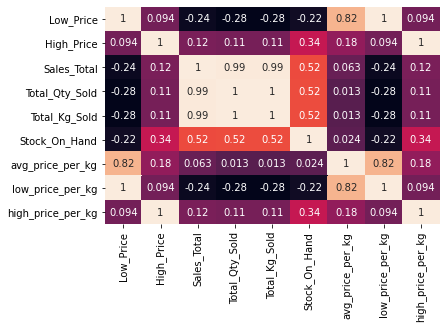

In [28]:
# Check for multicollinearity
sns.heatmap(apples.corr(), annot=True, cbar=False);

Excluding the average prices per kg, there's high correlation between **Sales_Total, Total_Qty_Sold** and **Total_Kg_Sold**. For determining inventory levels, only **Total_Qty_Sold** will remain.

In [29]:
apples = apples[['Province', 'Date', 'Total_Qty_Sold', 'Stock_On_Hand', 
                 'avg_price_per_kg', 'low_price_per_kg', 'high_price_per_kg']]

In [30]:
apples.head()

,Province,Date,Total_Qty_Sold,Stock_On_Hand,avg_price_per_kg,low_price_per_kg,high_price_per_kg
4350,CAPE,2019-12-11,33.0,1117.0,9.70,4.17,11.67
4351,CAPE,2019-12-12,1151.0,2070.0,9.38,8.33,12.00
4352,CAPE,2019-12-14,63.0,2865.0,10.23,8.33,11.67
4353,CAPE,2019-12-23,1519.0,6017.0,5.47,3.33,16.67
4354,CAPE,2019-12-30,892.0,1272.0,6.53,4.17,11.67


In [31]:
apples['Province'].value_counts()

CAPE                    147
EASTERN CAPE             79
W.CAPE-BERGRIVER ETC     60
NATAL                    15
WEST COAST               15
TRANSVAAL                14
ORANGE FREE STATE         2
Name: Province, dtype: int64

In [32]:
apples['weekday'] = filtered_df['Date'].apply(lambda x: x.day_name())

In [ ]:
#apples.head()

In [33]:
apples.sort_values('Date', inplace=True)

In [ ]:
#apples.head()

In [34]:
apples['month'] = apples['Date'].apply(lambda x: x.month_name())

In [ ]:
#apples.head()

In [35]:
def season(month):
    """
    Returns the season of which the month falls in
    
    Parameters
    -----------
    month: str
        The month of the year as a full month name
    
    Returns
    --------
    str:
        The season of the year
        
    Examples
    ---------
    >>> season('October')
    'spring'
    """
    
    # Seasons
    summer = ['December', 'January', 'February']
    autumn = ['March', 'April', 'May']
    winter = ['June', 'July', 'August']
    spring = ['September', 'October', 'November']
    
    if month in summer:
        return 'summer'
    elif month in autumn:
        return 'autumn'
    elif month in winter:
        return 'winter'
    else:
        return 'spring'

In [36]:
apples['season'] = apples['month'].apply(season)

In [37]:
apples.head()

,Province,Date,Total_Qty_Sold,Stock_On_Hand,avg_price_per_kg,low_price_per_kg,high_price_per_kg,weekday,month,season
4350,CAPE,2019-12-11,33.0,1117.0,9.70,4.17,11.67,Wednesday,December,summer
4351,CAPE,2019-12-12,1151.0,2070.0,9.38,8.33,12.00,Thursday,December,summer
80382,W.CAPE-BERGRIVER ETC,2019-12-14,4.0,162.0,14.00,14.00,14.00,Saturday,December,summer
17031,EASTERN CAPE,2019-12-14,42.0,576.0,6.00,6.00,6.00,Saturday,December,summer
4352,CAPE,2019-12-14,63.0,2865.0,10.23,8.33,11.67,Saturday,December,summer


In [38]:
apples['weekday'].value_counts()

Wednesday    71
Thursday     64
Monday       63
Tuesday      63
Saturday     38
Friday       33
Name: weekday, dtype: int64

In [39]:
apples['season'].value_counts()

winter    140
autumn     95
summer     65
spring     32
Name: season, dtype: int64

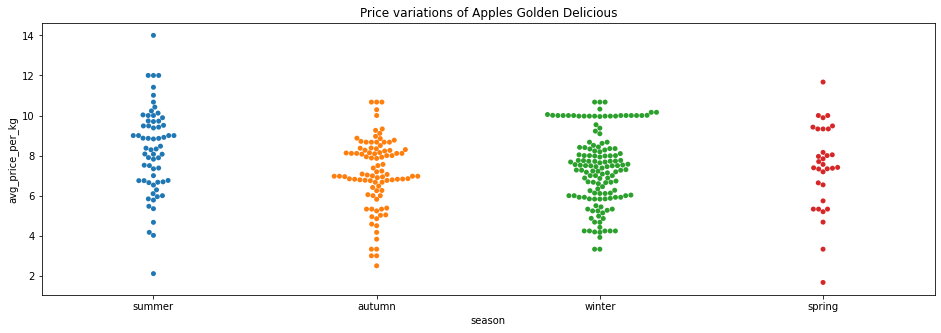

In [40]:
plt.figure(figsize=(16,5))
sns.swarmplot(x='season', y='avg_price_per_kg', data=apples)
plt.title("Price variations of Apples Golden Delicious");

In [41]:
apples['week_of_year'] = apples['Date'].apply(lambda x: x.week)

In [42]:
#apples.head()

In [43]:
apples['is_month_end'] = apples['Date'].apply(lambda x: 1 if x.day in range(25,32) else 0)

In [44]:
#apples.head()

In [45]:
apples['is_month_end'].value_counts()

0    261
1     71
Name: is_month_end, dtype: int64

In [46]:
apples.head()

,Province,Date,Total_Qty_Sold,Stock_On_Hand,avg_price_per_kg,low_price_per_kg,high_price_per_kg,weekday,month,season,week_of_year,is_month_end
4350,CAPE,2019-12-11,33.0,1117.0,9.70,4.17,11.67,Wednesday,December,summer,50,0
4351,CAPE,2019-12-12,1151.0,2070.0,9.38,8.33,12.00,Thursday,December,summer,50,0
80382,W.CAPE-BERGRIVER ETC,2019-12-14,4.0,162.0,14.00,14.00,14.00,Saturday,December,summer,50,0
17031,EASTERN CAPE,2019-12-14,42.0,576.0,6.00,6.00,6.00,Saturday,December,summer,50,0
4352,CAPE,2019-12-14,63.0,2865.0,10.23,8.33,11.67,Saturday,December,summer,50,0


In [47]:
df = apples[['Province', 'Total_Qty_Sold', 'Stock_On_Hand', 'avg_price_per_kg', 'weekday', 'month', 'season', 'is_month_end']]

In [49]:
#df.head()

In [50]:
df = pd.get_dummies(df, drop_first=True)

In [51]:
df.head()

,Total_Qty_Sold,Stock_On_Hand,avg_price_per_kg,is_month_end,Province_EASTERN CAPE,Province_NATAL,Province_ORANGE FREE STATE,Province_TRANSVAAL,Province_W.CAPE-BERGRIVER ETC,Province_WEST COAST,...,month_January,month_July,month_June,month_March,month_May,month_October,month_September,season_spring,season_summer,season_winter
4350,33.0,1117.0,9.70,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4351,1151.0,2070.0,9.38,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
80382,4.0,162.0,14.00,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
17031,42.0,576.0,6.00,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4352,63.0,2865.0,10.23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [52]:
X = df.drop('avg_price_per_kg', axis=1)
y = df['avg_price_per_kg']

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [57]:
lr = LinearRegression()

In [58]:
lr.fit(X_train, y_train)

LinearRegression()

In [59]:
predict = lr.predict(X_test)

In [68]:
rmse = np.sqrt(mean_squared_error(y_test, predict))

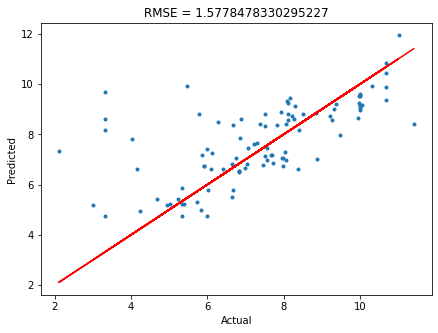

In [69]:
plt.figure(figsize=(7,5))
plt.plot(y_test, predict, '.')
plt.plot(y_test, y_test, 'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'RMSE = {rmse}');

In [70]:
from statsmodels.formula.api import ols

In [73]:
# The dependent variable:
y_name = 'avg_price_per_kg'

X_names = X_train.columns

# Build the OLS formula string " y ~ X "
formula_str = y_name+" ~ "+" + ".join(X_names)

In [75]:
# Fit the model using the model dataframe
model=ols(formula=formula_str, data=pd.concat([X_train, y_train], axis=1))
fitted = model.fit()

# Output the fitted summary
print(fitted.summary())

SyntaxError: invalid syntax (<unknown>, line 1)

In [1]:
import pandas as pd

In [2]:
df = pd.Series(['a', 'b', 'c'], index=[1, 2, 3])

In [3]:
df

1    a
2    b
3    c
dtype: object

In [4]:
df.loc[2]

'b'